In [1]:
import torch
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [2]:
os.environ['CUDA_LAUNCH_BLOCKING'] = '1'


In [3]:
path_to_dataset = 'C:\\Users\\daler\\PycharmProjects\\cats_breeds_classifier\\images\\'

In [4]:
dataset = datasets.ImageFolder(path_to_dataset)

In [23]:
torch.manual_seed(0)

In [24]:
def get_data(path_to_dataset):
    transform = transforms.Compose([
        transforms.RandomRotation(20),
        transforms.Resize((224,224)),
#        transforms.RandomResizedCrop(224),
        transforms.RandomHorizontalFlip(0.25),
        transforms.ToTensor()]
    )
    dataset = datasets.ImageFolder(path_to_dataset,transform=transform)
    train_count = int(0.9 * len(dataset))
    valid_count = int(0.05 * len(dataset))
    test_count = len(dataset) - train_count - valid_count
    train_dataset, valid_dataset, test_dataset = torch.utils.data.random_split(
    dataset, (train_count, valid_count, test_count))
    train = DataLoader(train_dataset, batch_size=32, shuffle=True)
    test = DataLoader(test_dataset, batch_size=32, shuffle=True)
    valid = DataLoader(valid_dataset, batch_size=32, shuffle=True)
    return train, test, valid

In [25]:
dataset = datasets.ImageFolder(path_to_dataset)
dataset.class_to_idx
rev_parm = dict((v, k) for k, v in dataset.class_to_idx.items())


In [28]:
len(rev_parm)

2

In [27]:
classes= list(rev_parm.values())

In [29]:
dataset = get_data(path_to_dataset)

In [30]:
train, test,  valid = get_data(path_to_dataset)

In [31]:
def train_imshow():
    dataiter = iter(train)
    images, labels = dataiter.next()
    fig, axes = plt.subplots(figsize=(10, 4), ncols=5)
    for i in range(5):
        ax = axes[i]
        ax.imshow(images[i].permute(1, 2, 0)) 
        print(rev_parm[(int(labels[i]))])
    plt.show()

Cat
Dog
Cat
Cat
Dog


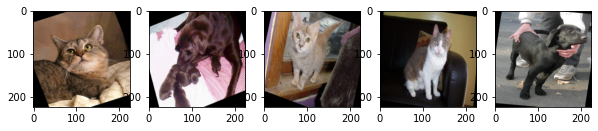

In [32]:
train_imshow()

In [33]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        # convolutional layer (sees 32x32x3 image tensor)
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        # convolutional layer (sees 16x16x16 tensor)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        # convolutional layer (sees 8x8x32 tensor)
        self.conv3 = nn.Conv2d(32, 64, 3, padding=1)
        # max pooling layer
        self.pool = nn.MaxPool2d(2, 2)
        # linear layer (64 * 4 * 4 -> 500)
        self.fc1 = nn.Linear(64*28*28, 200)
        # linear layer (500 -> 10)
        self.fc2 = nn.Linear(200, len(rev_parm))
        # dropout layer (p=0.25)
        self.dropout = nn.Dropout(0.25)

    def forward(self, x):
        # add sequence of convolutional and max pooling layers
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        
        x = self.pool(F.relu(self.conv3(x)))
        # flatten image input
        x = x.view(-1,64*28*28)
        
        # add dropout layer
        x = self.dropout(x)
        # add 1st hidden layer, with relu activation function
        x = F.relu(self.fc1(x))
        # add dropout layer
        x = self.dropout(x)
        # add 2nd hidden layer, with relu activation function
        x = self.fc2(x)
        return x
net = Net()

In [34]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [35]:
if torch.cuda.is_available(): # Checking if we can use GPU
    net = net.cuda()
    criterion = criterion.cuda()

device = torch.device("cuda:0")

In [36]:
train_on_gpu = torch.cuda.is_available()

In [38]:
%%time
# number of epochs to train the model
n_epochs = 2

valid_loss_min = np.Inf # track change in validation loss

for epoch in range(1, n_epochs+1):

    # keep track of training and validation loss
    train_loss = 0.0
    valid_loss = 0.0
    
    ###################
    # train the model #
    ###################
    net.train()
    for data, target in train:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # clear the gradients of all optimized variables
        optimizer.zero_grad()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = net(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # backward pass: compute gradient of the loss with respect to model parameters
        loss.backward()
        # perform a single optimization step (parameter update)
        optimizer.step()
        # update training loss
        train_loss += loss.item()*data.size(0)
        
    ######################    
    # validate the model #
    ######################
    net.eval()
    for data, target in valid:
        # move tensors to GPU if CUDA is available
        if train_on_gpu:
            data, target = data.cuda(), target.cuda()
        # forward pass: compute predicted outputs by passing inputs to the model
        output = net(data)
        # calculate the batch loss
        loss = criterion(output, target)
        # update average validation loss 
        valid_loss += loss.item()*data.size(0)
    
    # calculate average losses
    train_loss = train_loss/len(train.sampler)
    valid_loss = valid_loss/len(valid.sampler)
        
    # print training/validation statistics 
    print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
        epoch, train_loss, valid_loss))
    
    
    
    # save model if validation loss has decreased
    if valid_loss <= valid_loss_min:
        print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
        valid_loss_min,
        valid_loss))
        torch.save(net.state_dict(), 'model_cats_breeds_dogs1.pt')
        valid_loss_min = valid_loss

Epoch: 1 	Training Loss: 0.127976 	Validation Loss: 0.396507
Validation loss decreased (inf --> 0.396507).  Saving model ...
Epoch: 2 	Training Loss: 0.120234 	Validation Loss: 0.433834
Wall time: 3min 52s


In [51]:
net.load_state_dict(torch.load('model_cats_breeds_dogs1.pt'))


<All keys matched successfully>

In [52]:
# track test loss
test_loss = 0.0
class_correct = list(0. for i in range(16))
class_total = list(0. for i in range(16))
batch_size = 2

net.eval()
# iterate over test data
for data, target in test:
    # move tensors to GPU if CUDA is available
    if train_on_gpu:
        data, target = data.cuda(), target.cuda()
    # forward pass: compute predicted outputs by passing inputs to the model
    output = net(data)
    # calculate the batch loss
    loss = criterion(output, target)
    # update test loss 
    test_loss += loss.item()*data.size(0)
    # convert output probabilities to predicted class
    _, pred = torch.max(output, 1)    
    # compare predictions to true label
    correct_tensor = pred.eq(target.data.view_as(pred))
    correct = np.squeeze(correct_tensor.numpy()) if not train_on_gpu else np.squeeze(correct_tensor.cpu().numpy())
    # calculate test accuracy for each object class
    for i in range(batch_size):
        label = target.data[i]
        class_correct[label] += correct[i].item()
        class_total[label] += 1

# average test loss
test_loss = test_loss/len(test.dataset)
print('Test Loss: {:.6f}\n'.format(test_loss))

for i in range(2):
    if class_total[i] > 0:
        print('Test Accuracy of %5s: %2d%% (%2d/%2d)' % (
            classes[i], 100 * class_correct[i] / class_total[i],
            np.sum(class_correct[i]), np.sum(class_total[i])))
    else:
        print('Test Accuracy of %5s: N/A (no training examples)' % (classes[i]))

print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
    100. * np.sum(class_correct) / np.sum(class_total),
    np.sum(class_correct), np.sum(class_total)))

Test Loss: 0.359392

Test Accuracy of   Cat: 92% (46/50)
Test Accuracy of   Dog: 93% (28/30)

Test Accuracy (Overall): 92% (74/80)


In [53]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

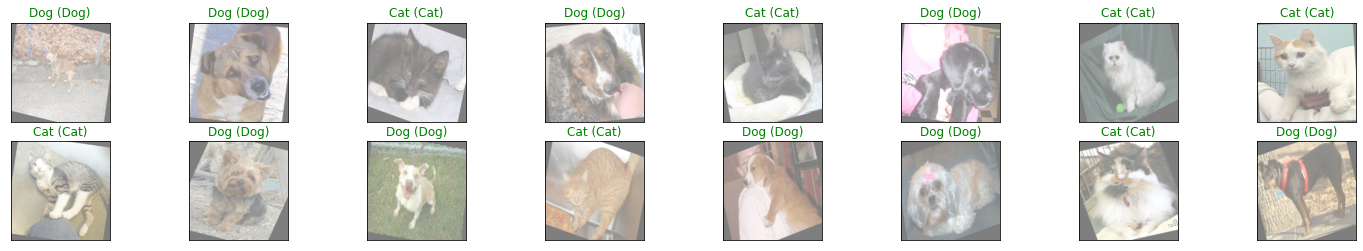

In [54]:
# obtain one batch of test images
dataiter = iter(test)
images, labels = dataiter.next()
images.numpy()

# move model inputs to cuda, if GPU available
if train_on_gpu:
    images = images.cuda()

# get sample outputs
output = net(images)
# convert output probabilities to predicted class
_, preds_tensor = torch.max(output, 1)
preds = np.squeeze(preds_tensor.numpy()) if not train_on_gpu else np.squeeze(preds_tensor.cpu().numpy())

# plot the images in the batch, along with predicted and true labels
fig = plt.figure(figsize=(25, 4))
for idx in np.arange(16):
    ax = fig.add_subplot(2, 8, idx+1, xticks=[], yticks=[])
    imshow(images[idx] if not train_on_gpu else images[idx].cpu())
    ax.set_title("{} ({})".format(classes[preds[idx]], classes[labels[idx]]),
                 color=("green" if preds[idx]==labels[idx].item() else "red"))

In [50]:
criterion = nn.CrossEntropyLoss()

optimizer = optim.SGD(net.parameters(), lr=0.01, momentum=0.9)

if torch.cuda.is_available(): # Checking if we can use GPU
    model = net.cuda()
    criterion = criterion.cuda()

device = torch.device("cuda:0")

def train_net(n_epoch): # Training our network
    losses = []
    for epoch in range(n_epoch):  # loop over the dataset multiple times
        running_loss = 0.0
        for i, data in enumerate(train, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels = data
            inputs, labels = inputs.to(device), labels.to(device)

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = net(inputs)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            # print statistics
            losses.append(loss)
            running_loss += loss.item()
            if i % 100 == 99:  # print every 2000 mini-batches
                print('[%d, %5d] loss: %.10f' %
                      (epoch + 1, i + 1, running_loss / 2000))
                running_loss = 0.0
    plt.plot(losses, label='Training loss')
    plt.show()
    print('Finished Training')

In [197]:
8388608/64/64/64

32.0

[1,   100] loss: 0.1427212898
[1,   200] loss: 0.1246392936
[1,   300] loss: 0.1219863379
[1,   400] loss: 0.1226082133
[1,   500] loss: 0.1208808467
[1,   600] loss: 0.1218927654
[1,   700] loss: 0.1217809950
[1,   800] loss: 0.1218760386


TypeError: can't convert cuda:0 device type tensor to numpy. Use Tensor.cpu() to copy the tensor to host memory first.

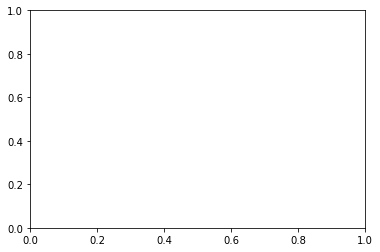

In [268]:
%%time
train_net(1)

In [270]:
losses

NameError: name 'losses' is not defined

In [211]:
if torch.cuda.is_available():# Checking if we can use GPU
    print(1)
    model = net.cuda()
    criterion = criterion.cuda()

1


In [212]:
model

Net(
  (conv1): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
  (pool): MaxPool2d(kernel_size=8, stride=8, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=16, out_features=100, bias=True)
  (fc2): Linear(in_features=100, out_features=50, bias=True)
  (fc3): Linear(in_features=50, out_features=2, bias=True)
)

In [235]:
for data, target in train:
    print(target)
    break

FileNotFoundError: [Errno 2] No such file or directory: 'C:\\Users\\daler\\PycharmProjects\\cats_breeds_classifier\\images\\Domestic Short Hair\\46709582_528.jpg'

In [236]:
train

In [66]:
filelist  = []

for dirname, _, filenames in os.walk('C:\\Users\\daler\\PycharmProjects\\cats_breeds_classifier\\images\\'):
    for filename in filenames:
        filelist.append (os.path.join(dirname, filename))

In [332]:
labels_needed = ['Bombay', 'Calico', 'Burmese', 'Himalayan',
'Munchkin', 'Ragdoll', 'Siberian', 'British Shorthair', 'Russian Blue', 
                 'Dilute Calico']

In [67]:
Filepaths   = []
labels = []
labels_needed = []
# for image_file in filelist:
#     label = image_file.split(os.path.sep)[-2]
#     if label in labels_needed:

#         Filepaths.append(image_file)
#         labels.append(label)  


for image_file in filelist:
    label = image_file.split(os.path.sep)[-2]
    if label not in labels_needed:

        labels_needed.append(label)
for image_file in filelist:
    label = image_file.split(os.path.sep)[-2]
    if label in labels_needed:

        Filepaths.append(image_file)
        labels.append(label)  

In [68]:
df = pd.DataFrame( list( zip (Filepaths, labels) ), columns = ['Filepath', 'Labels'] )
df

,Filepath,Labels
0,C:\Users\daler\PycharmProjects\cats_breeds_cla...,Abyssinian
1,C:\Users\daler\PycharmProjects\cats_breeds_cla...,Abyssinian
2,C:\Users\daler\PycharmProjects\cats_breeds_cla...,Abyssinian
3,C:\Users\daler\PycharmProjects\cats_breeds_cla...,Abyssinian
4,C:\Users\daler\PycharmProjects\cats_breeds_cla...,Abyssinian
...,...,...
19500,C:\Users\daler\PycharmProjects\cats_breeds_cla...,Siberian
19501,C:\Users\daler\PycharmProjects\cats_breeds_cla...,Siberian
19502,C:\Users\daler\PycharmProjects\cats_breeds_cla...,Siberian
19503,C:\Users\daler\PycharmProjects\cats_breeds_cla...,Siberian


In [69]:
from sklearn.utils import shuffle
df = (df.sample(frac = 1).reset_index()).drop(columns = 'index')
df

,Filepath,Labels
0,C:\Users\daler\PycharmProjects\cats_breeds_cla...,British Shorthair
1,C:\Users\daler\PycharmProjects\cats_breeds_cla...,Dogs
2,C:\Users\daler\PycharmProjects\cats_breeds_cla...,Maine Coon
3,C:\Users\daler\PycharmProjects\cats_breeds_cla...,Dogs
4,C:\Users\daler\PycharmProjects\cats_breeds_cla...,Russian Blue
...,...,...
19500,C:\Users\daler\PycharmProjects\cats_breeds_cla...,Persian
19501,C:\Users\daler\PycharmProjects\cats_breeds_cla...,Dogs
19502,C:\Users\daler\PycharmProjects\cats_breeds_cla...,Russian Blue
19503,C:\Users\daler\PycharmProjects\cats_breeds_cla...,Persian


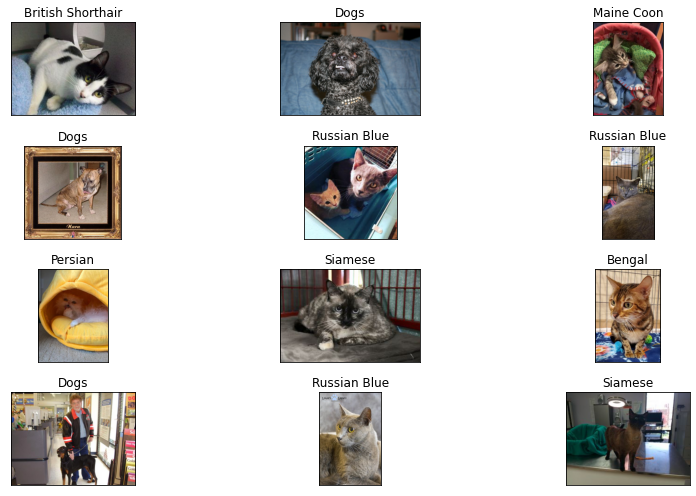

In [70]:
f,a = plt.subplots(nrows=4, ncols=3,figsize=(13, 7),
                        subplot_kw={'xticks': [], 'yticks': []})

for i, ax in enumerate(a.flat):
    ax.imshow(plt.imread(df.Filepath[i]))
    ax.set_title(df.Labels[i])
    
plt.tight_layout()
plt.show()

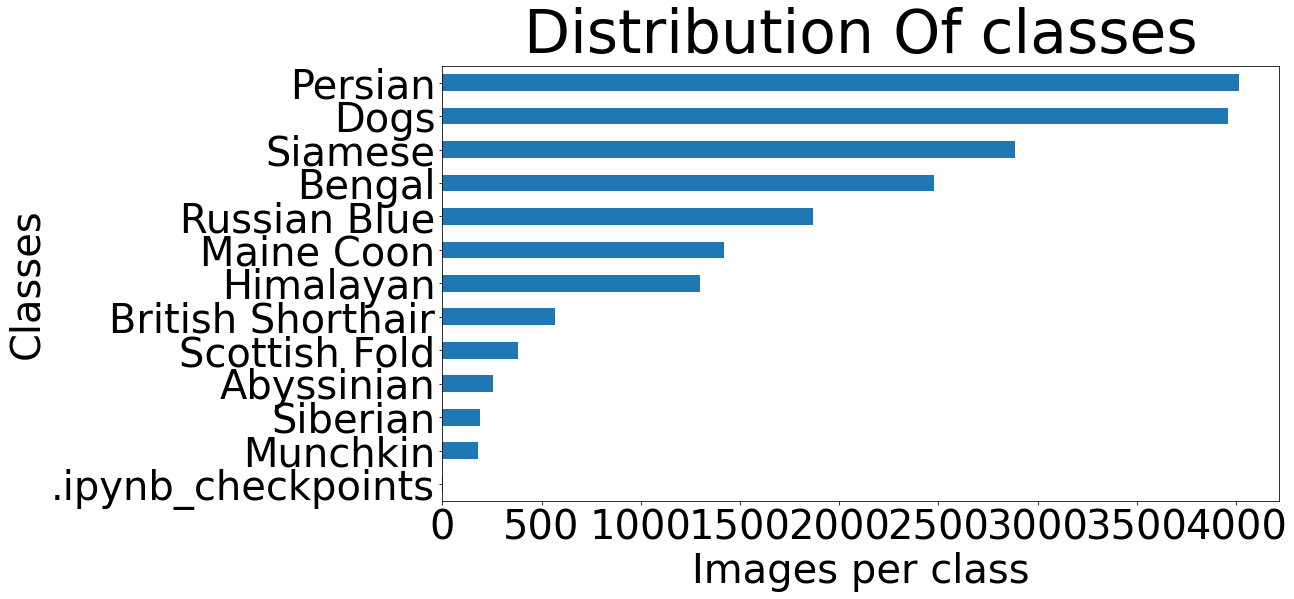

In [72]:
ax=pd.value_counts(df['Labels'],ascending=True).plot(kind='barh',
                                                       fontsize="40",
                                                       title="Distribution Of classes",
                                                       figsize=(15,8))
ax.set(xlabel="Images per class", ylabel="Classes")
ax.xaxis.label.set_size(40)
ax.yaxis.label.set_size(40)
ax.title.set_size(60)
plt.show()

In [10]:
df.Labels.value_counts()

Calico               3468
Dilute Calico        3230
Ragdoll              2669
Russian Blue         1870
Bombay               1835
Himalayan            1301
British Shorthair     567
Burmese               344
Siberian              189
Munchkin              181
Name: Labels, dtype: int64

In [11]:
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler
batch_size = 20
# percentage of training set to use as validation
valid_size = 0.2

# convert data to a normalized torch.FloatTensor
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
    ])

In [12]:
from torchvision import datasets

In [13]:
df

,Filepath,Labels
0,C:\Users\daler\PycharmProjects\cats_breeds_cla...,Bombay
1,C:\Users\daler\PycharmProjects\cats_breeds_cla...,Calico
2,C:\Users\daler\PycharmProjects\cats_breeds_cla...,Dilute Calico
3,C:\Users\daler\PycharmProjects\cats_breeds_cla...,Ragdoll
4,C:\Users\daler\PycharmProjects\cats_breeds_cla...,Bombay
...,...,...
15649,C:\Users\daler\PycharmProjects\cats_breeds_cla...,Calico
15650,C:\Users\daler\PycharmProjects\cats_breeds_cla...,Bombay
15651,C:\Users\daler\PycharmProjects\cats_breeds_cla...,British Shorthair
15652,C:\Users\daler\PycharmProjects\cats_breeds_cla...,Calico


In [29]:
import torch
import torchvision
from PIL import Image


class MyDataset(torch.utils.data.Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        return (
            torchvision.transforms.functional.to_tensor(Image.open(row["Filepath"])),
            row["Labels"],
        )
        if self.transform:
                sample = self.transform(sample)

In [ ]:
class FaceLandmarksDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.landmarks_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.landmarks_frame)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = os.path.join(self.root_dir,
                                self.landmarks_frame.iloc[idx, 0])
        image = io.imread(img_name)
        landmarks = self.landmarks_frame.iloc[idx, 1:]
        landmarks = np.array([landmarks])
        landmarks = landmarks.astype('float').reshape(-1, 2)
        sample = {'image': image, 'landmarks': landmarks}

        if self.transform:
            sample = self.transform(sample)

        return sample

In [17]:
path_to_dataset = 'C:\\Users\\daler\\PycharmProjects\\cats_breeds_classifier\\images\\'

In [21]:
transformed_dataset = FaceLandmarksDataset(csv_file='PycharmProjects/cats_breeds_classifier/data/cats.csv',
                                           root_dir='PycharmProjects/cats_breeds_classifier/images',
                                           transform=transforms.Compose([
                                               transforms.Resize(256),
                                               RandomCrop(224),
                                               ToTensor()
                                           ]))

for i in range(len(transformed_dataset)):
    sample = transformed_dataset[i]

    print(i, sample['image'].size(), sample['landmarks'].size())

    if i == 3:
        break

NameError: name 'FaceLandmarksDataset' is not defined

In [49]:
cuda = True
kwargs = {'num_workers': 1, 'pin_memory': True} if cuda else {}


In [43]:
from torchvision import datasets, transforms
import torch

def load_training(root_path, direct, batch_size, kwargs):
    transform = transforms.Compose(
        [transforms.Resize([256, 256]),
         transforms.RandomCrop(224),
         transforms.RandomHorizontalFlip(),
         transforms.ToTensor()])
    data = datasets.ImageFolder(root=root_path + dir, transform=transform)
    train_loader = torch.utils.data.DataLoader(data, batch_size=batch_size, shuffle=True, drop_last=True, **kwargs)
    return train_loader

In [ ]:
Abbysinian

In [50]:
load_training(path_to_dataset,'Abbysinian', 16, kwargs  )

TypeError: can only concatenate str (not "builtin_function_or_method") to str

In [80]:
dataset = datasets.ImageFolder(path_to_dataset, transform=transforms.ToTensor())

lengths = [int(np.ceil(0.95*len(dataset))),
           int(np.floor(0.05*len(dataset)))]
train_set, test_set = torch.utils.data.random_split(dataset, lengths)

train_dataloader = torch.utils.data.DataLoader(train_set, batch_size=64)
test_dataloader = torch.utils.data.DataLoader(test_set, batch_size=64)

In [81]:
torchvision.transforms.To

[120278, 6330]

In [37]:
ds = MyDataset(df, transform=transforms.Compose([
                                               torchvision.transforms.Resize(64),
                                               torchvision.transforms.RandomCrop(224),
                                               ToTensor()]))

In [38]:
ds.dataframe

Compose(
    Resize(size=64, interpolation=bilinear)
    RandomCrop(size=(224, 224), padding=None)
)

In [39]:
dataloader = torch.utils.data.DataLoader(ds, batch_size=64, shuffle=True)

In [49]:
dataloader

In [53]:
ds.dataframe

,Filepath,Labels
0,C:\Users\daler\PycharmProjects\cats_breeds_cla...,Himalayan
1,C:\Users\daler\PycharmProjects\cats_breeds_cla...,Dilute Calico
2,C:\Users\daler\PycharmProjects\cats_breeds_cla...,Bombay
3,C:\Users\daler\PycharmProjects\cats_breeds_cla...,Calico
4,C:\Users\daler\PycharmProjects\cats_breeds_cla...,Calico
...,...,...
15649,C:\Users\daler\PycharmProjects\cats_breeds_cla...,Russian Blue
15650,C:\Users\daler\PycharmProjects\cats_breeds_cla...,Calico
15651,C:\Users\daler\PycharmProjects\cats_breeds_cla...,Dilute Calico
15652,C:\Users\daler\PycharmProjects\cats_breeds_cla...,Calico


In [40]:
for images, scores in dataloader:
    Image.open(images)
    print(images, scores)
    break

RuntimeError: stack expects each tensor to be equal size, but got [3, 369, 300] at entry 0 and [3, 291, 300] at entry 1

In [2]:
import cv2
import os

def load_images_from_folder(folder):
    images = []
    for filename in os.listdir(folder):
        img = cv2.imread(os.path.join(folder,filename))
        if img is not None:
            images.append(img)
    return images

In [33]:
images = load_iimages[:2]mages_from_folder('C://Users//daler//PycharmProjects/cats_breeds_classifier/images/Abyssinian/')

In [75]:
import torch
from torchvision import transforms
from PIL import Image

In [106]:
p = transforms.Compose([transforms.Resize((96,96))])

In [107]:
img = Image.open('C://Users//daler//PycharmProjects/cats_breeds_classifier/images/Abyssinian/12136161_252.jpg')

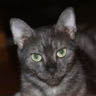

In [112]:
img

In [105]:
 images[50].shape

(199, 300, 3)

In [60]:
images[0][0][0]

array([ 5,  5, 11], dtype=uint8)

In [63]:
def imshow(img):
    img = img / 2 + 0.5  # unnormalize
    plt.imshow(np.transpose(img, (1, 2, 0)))  # convert from Tensor image

C:\Users\daler\AppData\Local\Temp/ipykernel_4528/1335727298.py:5: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])


TypeError: Invalid shape (300, 3, 295) for image data

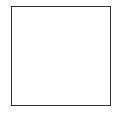

In [16]:
fig = plt.figure(figsize=(25, 4))

# display 20 images
for idx in np.arange(20):
    ax = fig.add_subplot(2, 20/2, idx+1, xticks=[], yticks=[])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

In [7]:
load_images_from_folder('C://Users//daler//PycharmProjects/cats_breeds_classifier/images/Abyssinian/')

array([[[ 5,  5, 11],
        [ 5,  5, 11],
        [ 5,  5, 11],
        ...,
        [ 2,  5,  9],
        [ 2,  5,  9],
        [ 2,  5,  9]],

       [[ 5,  5, 11],
        [ 5,  5, 11],
        [ 5,  5, 11],
        ...,
        [ 3,  6, 10],
        [ 3,  6, 10],
        [ 3,  6, 10]],

       [[ 5,  5, 11],
        [ 5,  5, 11],
        [ 5,  5, 11],
        ...,
        [ 3,  6, 10],
        [ 3,  6, 10],
        [ 3,  6, 10]],

       ...,

       [[ 9, 19, 37],
        [ 9, 19, 37],
        [ 9, 19, 37],
        ...,
        [33, 39, 52],
        [32, 38, 51],
        [30, 36, 49]],

       [[ 9, 19, 37],
        [ 9, 19, 37],
        [ 9, 19, 37],
        ...,
        [39, 45, 58],
        [37, 43, 56],
        [36, 42, 55]],

       [[ 9, 19, 37],
        [ 9, 19, 37],
        [ 9, 19, 37],
        ...,
        [41, 47, 60],
        [40, 46, 59],
        [39, 45, 58]]], dtype=uint8)